# Regularisation in Linear Regression 

* Topic: Regularisation
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Clarke, Simon Bowly, Kaustav Das
* Version: 4.1

In this notebook we will explore the technique of **regularisation** in linear regression models. We have seen how coefficients can vary signficantly across different subsets of data due to overfitting; regularisation is a method which can alleviate this problem, leading to more consistent results.

We will use the Diabetes dataset to explore these methods, as we did in the [multi-linear regression notebook](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Regression/Multivariate-Linear-Regression.ipynb). Please review the content there if this is not familiar.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression, Lasso, Ridge  # models we are going to use
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import r2_score # for comparing the predicted and test values
import seaborn as sns

plt.rcParams['figure.figsize'] = [8, 6]

## Recall: Multivariate Linear Regression

Following on from previous work on multilinear regression, we read in the data, check correlations, construct normalised features, and fit a regression model.

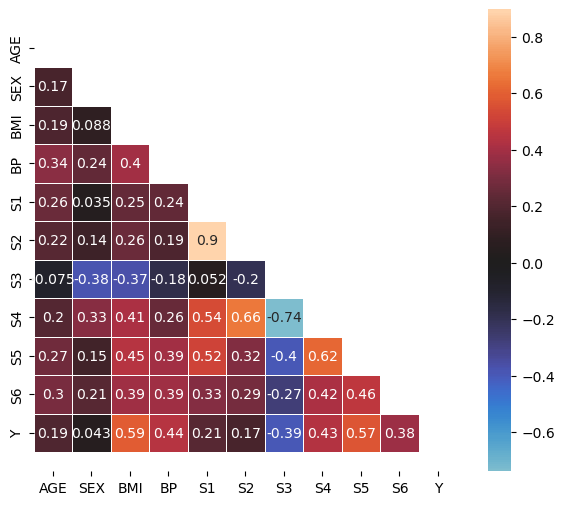

In [2]:
df = pd.read_csv('Diabetes_Data.csv', usecols = range(0, 11)) # read the Diabetes dataset in to a pandas dataframe

corrs = df.corr() # calculate the correlation table
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=bool)) 
f, ax = plt.subplots() # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

In [3]:
X = df.drop(['Y'],axis=1) # drop Y from our dataframe
Y = df['Y'] # create a dataframe with just the Y values
nX =(X-X.mean())/X.std() # create nX, a normalised version of X
feature_names = X.columns

In [4]:
# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y,
    test_size=0.2,
    random_state=1235
) 

linear = LinearRegression() # instantatiate the linear regression model
linear.fit(X_train, Y_train) # fit the data to the model
training_score = linear.score(X_train, Y_train) # calculate rsq for the training set

# use the independent variables for the testing set to predict the target variable
preds_linear = linear.predict(X_test) 

# calculate the correlation of the predicted and actual target variables
rsquared_linear = r2_score(Y_test, preds_linear) 

# print the training and testing scores
print(f'Training score is {training_score:.3f}')
print(f'Testing score is {rsquared_linear:.3f}')

Training score is 0.532
Testing score is 0.450


With this initial model fitted, we investigate coefficient variability using the `sklearn` methods `cross_validate` and `RepeatedKFold`. The first of these performs a number of runs of a model. The second splits the data in n sections and repeats the calculations m times. This gives n.m runs to investigate the variability of the coefficients. The variability of these can then be plotted using a boxplot.

We can see `AGE`, `SEX`, `BP`, `BMI` and `S6` have very low variance, whereas `S1`-`S5` have high variance due to overfitting. Of the low variance features, `AGE` and `S6` seem to have little effect on the predictions.

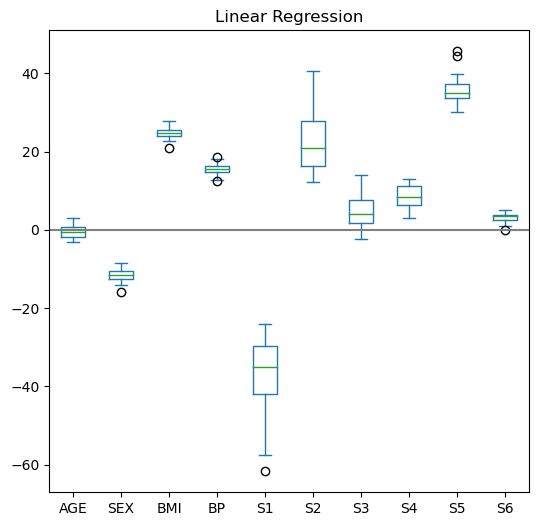

In [5]:
# cross_validate takes the particular model, in this case linear regression which we instantatiated earlier,
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(
    linear, nX, Y, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=23),
    return_estimator=True
)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']],columns=feature_names)
# plot the descriptive statics of the coefficients in a box and whisker plot to show variability
ax = coefs.plot(kind='box')
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

## Bias-Variance Tradeoff

An important pheonomon in Supervised Machine Learning is the so-called *Bias-Variance Tradeoff*. Suppose we have data points $(x_{1,1}, \dots, x_{1,P}, y_1), \dots, (x_{N,1},\dots, x_{N,P}, y_N)$ (so that we have $N$ data points and $P$ features). We assume that each target $y_i$ can be represented via the relationship

$$
y = f(x) + \varepsilon
$$

where $f$ is a function that represents the 'true' model and $\varepsilon$ represents some inevitable noise. The main objective of Supervised Machine Learning is to estimate the true model $f$ via some other predictive function (i.e. learning model) $\hat f$. For example, in univariate linear regression, $\hat f(x) = mx + c$. We can define the mean square error (MSE) between $y$ and the predictive function $\hat f$ as

$$
\text{MSE} = E \big [\big(y - \hat f(x)\big)^2\big ]
$$
where E refers to the expectation operator from probability theory. Typically we desire to reduce MSE.

It can be shown (through a lengthy calculation!) that MSE can be decomposed as:

$$
\text{MSE} = \text{Variance} + \text{Bias}^2 + \text{Irreducible error}
$$
where 

\begin{eqnarray*}
\text{Variance} &=& E \big [ \big(\hat f(x) - E(\hat f(x) \big)^2\big ], \\
\text{Bias} &=& y - E(\hat f(x)), \\
\text{Irreducible error} &=& E( \varepsilon^2).
\end{eqnarray*}

These objects refer to sources of error. Intuitively:
- Bias: Represents an unrealistic assumption in the character in the model. E.g., assuming a linear relationship when this is not true. 
- Variance: Represents the spread of the learning model $\hat f$ around its mean. 
- Irreducible error: This is the variance of the inevitable noise $\varepsilon$.

Bias and Variance refer to errors in our learning model $\hat f$, whereas Irreducible error refers to error that exists regardless of what we do.

For our learning model to perform well, we wish to reduce the Bias and Variance sources of error (we cannot play with the Irreducible error). Unfortunately, there is a tradeoff, reducing Bias usually leads to an increase in Variance and vice-versa. Typically we prefer to reduce Variance at the cost of an increased Bias.

Bias and Variance can be used to define two phenonomena in machine learning:

1. Underfitting: A model is underfitted if it has high Bias.
2. Overfitting: A model is overfitted if it has high Variance.

It turns out that in linear models, the usual OLS estimator has zero Bias, however possesses a high Variance, leading to a high chance of overfitting. It is therefore desirable to determine ways to reduce Variance in linear models. One way to do this is through the process of *regularisation*.

## Regularisation 

What we observe in the our experiments above is significant *variance* in the fitted model. The term *variance* has dual meanings here:

1. The model coefficients vary significantly when fitted to different subsets of the data (this is what we are testing using RepeatedKFold), and
2. The error rates vary significantly between training and testing (note the R^2 values above are 0.53 for training and 0.44 for testing).

We'll now investigate regularisation techniques for Linear Regression, to reduce the variance of the model. In general, a regularisation method adds a term to the cost function used by a model-fitting algorithm which penalises large model coefficient values. Recall that a linear regression model attempts to minimise the cost function:

$$
\sum_{i = 1}^N \left( y^{\text{predicted}}_i - y^{\text{actual}}_i  \right)^2.
$$

Typically we use a gradient descent algorithm to fit the model, and this has the effect of minimising the root mean squared error (RMSE) on the training data. A regularised model adjusts the optimisation process. Instead of just minimising the cost function, we add in an inequality constraint. Specifically, the objective of a regularisation model is to minimise

$$
\sum_{i = 1}^N \left( y^{\text{predicted}}_i - y^{\text{actual}}_i  \right)^2
$$

subject to

$$
\sum_{j = 1}^P g(m_j) < t
$$

where $m_j$ are the values of the model coefficients, and $g$ is some function, and $t > 0$. This is called a *constrained optimisation problem*. By doing some clever mathematics, we can actually show that this constrained optimisation problem is equivalent to minimising a new cost function

$$
\sum_{i = 1}^N \left( y^{\text{predicted}}_i - y^{\text{actual}}_i  \right)^2 + \alpha \sum_{j = 1}^P g(m_j).
$$

This new cost function represents two objectives; minimising the error rate on the training data, and minimising the variance of the model. The weighting between these two objectives is controlled by the so-called tuning parameter alpha ($\alpha$). We have to choose this parameter ourselves, and if chosen correctly, the fitting algorithm should reduce the size of the model coefficients, while maintaining a similar error rate. This is also why these regularisation techniques are called *shrinking methods*, since we are utilising a constraint in order to shrink the model coefficients, thereby altering feature importance and reducing variance in our model.

There are two main types of regularisation: Ridge and Lasso. In Ridge regularisation, the function $g$ is $g(x) =x^2$, so that the new cost function is 

$$
\sum_{i = 1}^N \left( y^{\text{predicted}}_i - y^{\text{actual}}_i  \right)^2 + \alpha \sum_{j = 1}^P m_j^2,
$$

whereas for Lasso regularisation, the function $g$ is $g(x) = |x|$, so that the new cost function for Lasso is 

$$
\sum_{i = 1}^N \left( y^{\text{predicted}}_i - y^{\text{actual}}_i  \right)^2 + \alpha \sum_{j = 1}^P |m_j|.
$$


We'll compare both below. To achieve a good result, we'll need to experiment with the tuning parameter *alpha* which controls the balance between the error measure and the penalty term in the cost function. Also, note that it is important to normalise the feature data so that the effect of regularisation is applied uniformly across all coefficients in the model.

### Ridge regularisation

To use Ridge regularisation (also known as $L^2$ regularisation since it adds a penalty term which is proportional to the sum of the squares of the coefficients), we need to find the optimal value of tuning parameter alpha. Generally this would be done using `RidgeCV`, however here we will graphically compare the training and testing scores. What we want to determine is the value of alpha for which we obtain the maximum value of the testing score. To generate the figure we create an array of alpha values, which in this case are logarithmically distributed, and perform a Ridge regularisation for each, and store the testing and training scores ( $R^2$ ). Then we plot these against alpha. From the figure we see the optimal value occurs at alpha approximately 100.

Optimal alpha is 100.000
Training score with optimal alpha is 0.532
Testing score with optimal alpha is 0.467


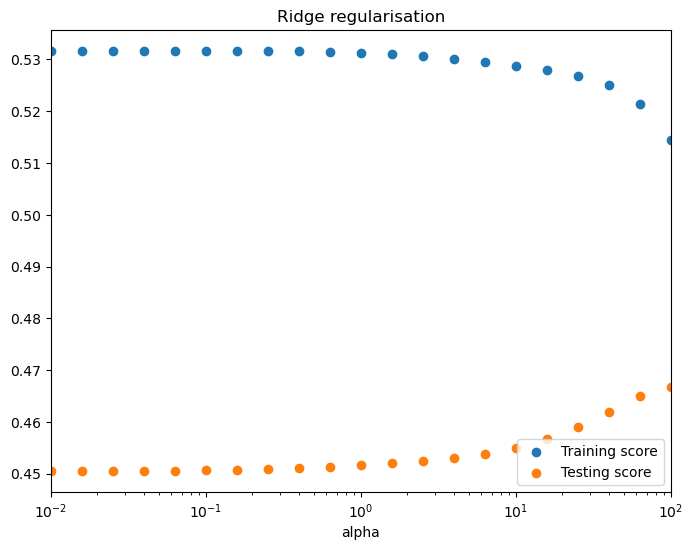

In [6]:
# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2, 2, num=21) 

# create two arrays for storage of the same size as alfas, but filled with zeros
ridge_training_score = np.zeros_like(alfas)
ridge_rsquared = np.zeros_like(alfas)

# loop over the values in the alfas array, at each loop the current value is alfa 
# and idx is incremented by 1, starting at 0
for idx, alfa in enumerate(alfas): 
    ridge = Ridge(alpha=alfa, random_state=1235) # instantatiate Ridge regularisation with the current alfa
    ridge.fit(X_train,Y_train) # train the model to our data set
# calculate the training score and store in the array ridge_training_score
    ridge_training_score[idx] = ridge.score(X_train, Y_train) 
    preds_linear = ridge.predict(X_test) # calculate the model prediction for the test data
# calculate the correlation between the predicted and actual test data and store in the  array ridge_rsquared
    ridge_rsquared[idx] = r2_score(Y_test,preds_linear)    
    
plt.scatter(alfas, ridge_training_score, label = 'Training score') # plot the training score against alpha
plt.scatter(alfas, ridge_rsquared, label = 'Testing score') # plot the testing score against alpha
plt.xscale('log') # make the x-axis a logarithmic scale
plt.gca().set_xlim(left=.01, right=100); # fix the x-axis limits
plt.title('Ridge regularisation')
plt.xlabel('alpha');
plt.legend(loc = 'best');

opt_alfa = alfas[np.argmax(ridge_rsquared)]
print(f'Optimal alpha is {opt_alfa:.3f}')
print(f'Training score with optimal alpha is {np.max(ridge_training_score):.3f}')
print(f'Testing score with optimal alpha is {np.max(ridge_rsquared):.3f}')

Now we can investigate Ridge regularisation using the optimal value of alpha approximately 100. Now we see significantly reduced variance in the coefficient and that the most important variables are `BMI`, `BP` and `S5`.

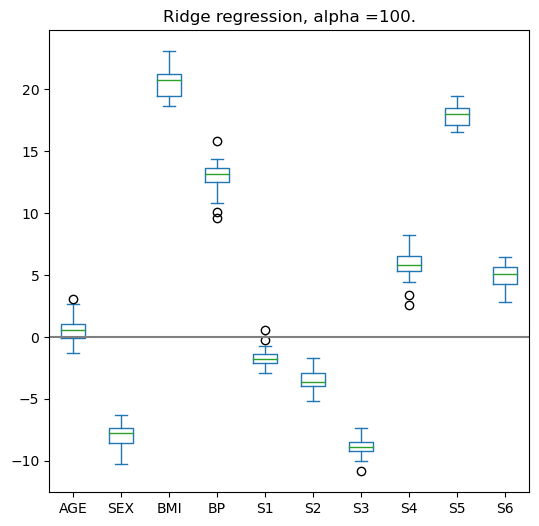

In [7]:
# cross_validate takes the particular model, in this case ridge regularisation
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(
    Ridge(alpha = 100.), 
    nX, Y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=2312),
    return_estimator=True
)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']], columns=feature_names)

# plot the descriptive statics of the coefficients in a box and whisker plot to show variability
ax = coefs.plot(kind='box')
plt.title('Ridge regression, alpha =100.')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

### Lasso regularisation

We can repeat the same process for Lasso regularisation (Least Absolute Shrinkage and Selection Operator), which adds a penalty term which is proportional to the sum of the absolute values of the coefficients. Here the optimal value for alpha is approximately 4.

Optimal alpha is 3.981
Training score with optimal alpha is 0.532
Testing score with optimal alpha is 0.473


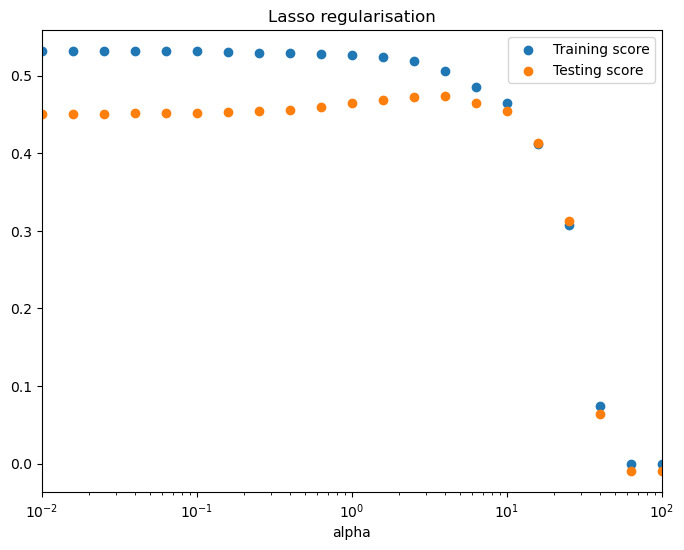

In [8]:
# create two arrays for storage of the same size as alfas, but filled with zeros
lasso_training_score = np.zeros_like(alfas)
lasso_rsquared = np.zeros_like(alfas)

# loop over the values in the alfas array, at each loop the current value is alfa 
# and idx is incremented by 1, starting at 0
for idx, alfa in enumerate(alfas): 
    lasso = Lasso(alpha=alfa) # instantatiate Lasso regularisation with the current alfa
    lasso.fit(X_train,Y_train) # train the model to our data set
# calculate the training score and store in the array lasso_training_score
    lasso_training_score[idx] = lasso.score(X_train,Y_train) 
    preds_linear = lasso.predict(X_test) # calculate the model prediction for the test data
# calculate the correlation between the predicted and actual test data and store in the  array lasso_rsquared
    lasso_rsquared[idx] = r2_score(Y_test,preds_linear)    
    
plt.scatter(alfas, lasso_training_score, label = 'Training score') # plot the training score against alpha
plt.scatter(alfas, lasso_rsquared, label = 'Testing score') # plot the testing score against alpha
plt.xscale('log') # make the x-axis a logarithmic scale
plt.gca().set_xlim(left = .01, right = 100); # fix the x-axis limits
plt.title('Lasso regularisation')
plt.xlabel('alpha');
plt.legend(loc='best');

opt_alfa = alfas[np.argmax(lasso_rsquared)]
print(f'Optimal alpha is {opt_alfa:.3f}')
print(f'Training score with optimal alpha is {np.max(lasso_training_score):.3f}')
print(f'Testing score with optimal alpha is {np.max(lasso_rsquared):.3f}')

Again, it can be seen that the most significant variables are `BMI`, `BP` and `S5`. In this case the coefficients for `AGE`, `S2` and `S4` are zero or close to zero.

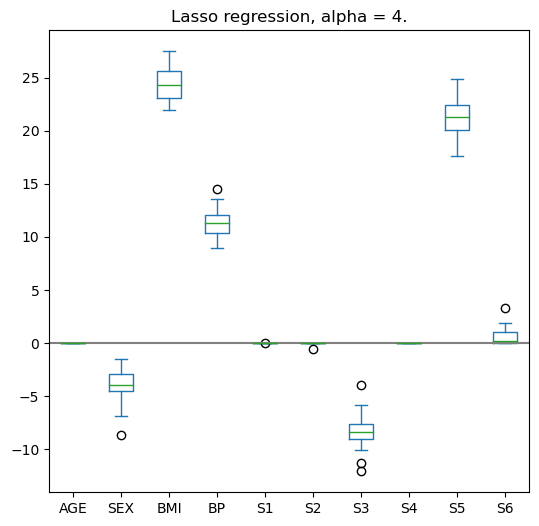

In [9]:
# cross_validate takes the particular model, in this case lasso regularisation
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(
    Lasso(alpha = 4.), nX, Y, 
    cv=RepeatedKFold(n_splits = 5, n_repeats = 5),
    return_estimator = True
)
# Take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']], columns = feature_names)

# plot the descriptive statics of the coefficients in a box and whisker plot to show variability
ax = coefs.plot(kind='box')
plt.title('Lasso regression, alpha = 4.')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

### Multicollinearity

You will notice that several of the regression coefficient distributions differ significantly between the original linear model and the models regularised using Lasso or Ridge regression.  The key examples here are `S1` to `S4`; in particular observe that S3 has gone from a positive effect to a negative effect which S2 and S4 have little to no effect.

We can look back at the correlation table to explain why this change occurs: it is due to multicollinearity.  The correlation table shows that some of our input variables (`S1` to `S4`) have relatively strong correlations with one another.  When we fit a linear model to input data containing two correlated variables A and B, we can produce multiple models with equivalent error by increasing the coefficient of A, while decreasing the coefficient of B to counteract the effect.  Introducing regularisation tends to reduce this effect by introducing a penalty for the training algorithm's tendency to increase the coefficient values.   The results of these regularised models indicate that we could potentially remove `S2` and `S4` from the model; they are strongly correlated with `S1` and `S3` respectively so do not contribute useful information.
